## 21. 경사하강법 심화

### import

In [45]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

for i in [pd, np, sklearn, mpl, sns]:
    print(i.__name__, i.__version__)

pandas 0.25.1
numpy 1.18.5
sklearn 0.21.3
matplotlib 3.5.3
seaborn 0.12.2


### 1. 경사 하강법 심화

#### 경사 하강법 리뷰
- 목적 함수의 기울기를 따라 모수를 갱신하는 반복적 최적화 알고리즘

> $𝛉=𝛉−\eta\nabla_{𝛉}𝐽(𝛉)$
> 
> $J(\mathbf{\theta})$: 목적 함수 (Objective Function)
> 
> $\eta$: 학습률 (Learning Rate)
> 
> $\Rightarrow$ 많은 데이터와 복잡한 모델을 위해서 효율화가 필요

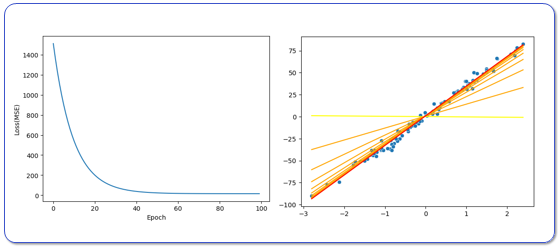

### 2. 확률적 경사 하강법
- 배치(Batch) 경사 하강법 vs 확률적(Stochastic) 경사 하강법
- 배치 경사 하강법: 전체 데이터를 한 번에 경사도를 구한 다음 모수를 업데이트

- 1 에폭(t)
> 1. 모수 초기화
>
> 2. 전체 데이터에서 손실과 기울기 계산
>
> 3. 모수 업데이트
>
> 4. 종료 조건을 충족하지 않으면 2단계로 이동

- 확률적 경사 하강법

> 아이디어: 전체 데이터에서 데이터의 일부를 샘플링하여 손실을 근사화하여 계산 효율화
>
> $𝐽(𝜃)=\frac{1}{}\sum_{𝑖=1}^𝑁𝑓(𝑦𝑖,h_𝜃(𝐱_𝑖))$
>
> $\Rightarrow$  위치 인덱스를 샘플링($B \subset {1, 2, ... N}$)
> 
> $\tilde{𝐽}(𝜃)=\frac{1}{|𝐵|}\sum_{𝑖∈𝐵}𝑓(𝑦_𝑖,h_𝜃(𝐱_𝑖))$
>
> $\tilde{𝐽}(𝜃) \approx 𝐽(𝜃)$
>
> $\Rightarrow$ 일부의 데이터로 전체의 데이터를 대표하기 위해서는 효과적인 샘플링 방법이 필요


- 표본 추출의 효율화 

> M: 배치 크기
> 
> 1. 전체 데이터를 섞음 (shuffle)
>
> 2. 순차적으로 M 개의 표본 선택
>
> 3. 선택할 표본이 없을 때 까지 2부터 반복

$\Rightarrow$ 전체 데이터를 효과적으로 균등하게 샘플링

#### 수행 과정

- M: 배치 크기

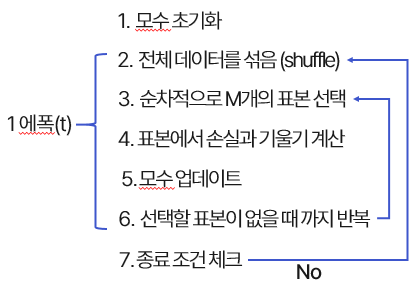

- $\tilde{𝐽}(𝜃)=\frac{1}{|𝐵|}\sum_{𝑖∈j:j+n}𝑓(𝑦_𝑖,h_𝜃(𝐱_𝑖))$

#### 배치 크기에 따른 학습 추이

- 배치 크기가 작을 수록 불안정

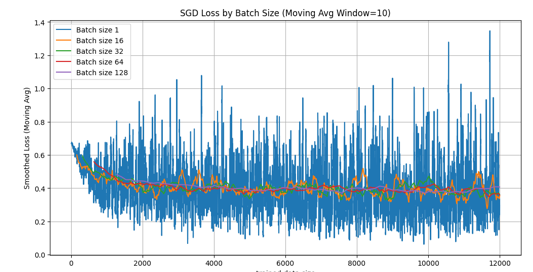

$\Rightarrow$ 표본이 전체를  반영할 수 있는 배치의 크기를 찾을 필요가 있다.

**[Ex.1]**

<div style="border: 1px solid #ddd; padding: 12px; margin-top: 10px;">
배치 크기에 따른 손실을 출력하여 학습의 추이를 봅니다.
</div>

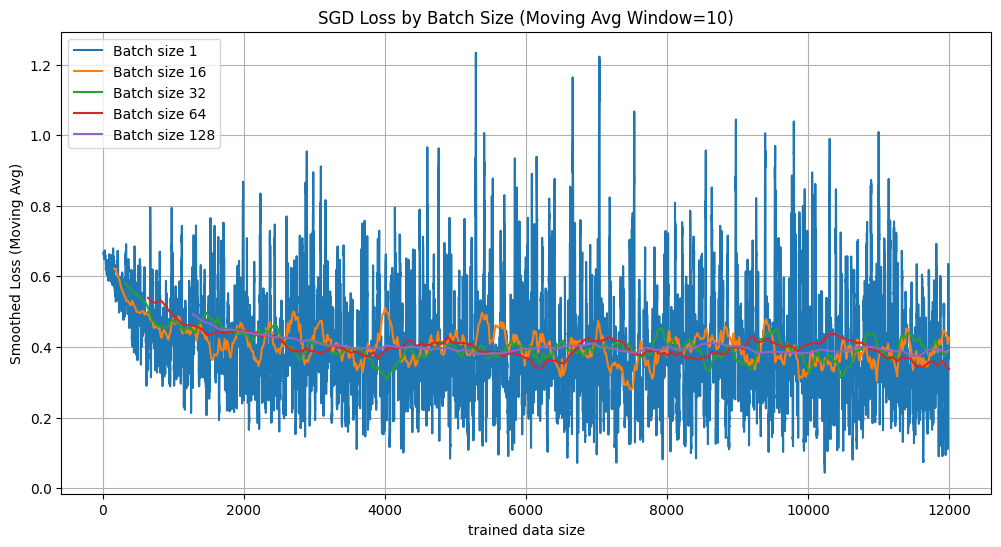

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score

def moving_average(x, window=100):
    return np.convolve(x, np.ones(window)/window, mode='valid')

# 데이터 생성
X, y = make_classification(n_samples=5000, n_features=20, n_informative=15,
                           n_redundant=0, n_classes=2, random_state=42, class_sep=1.0)

# 훈련 / 테스트 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 배치 사이즈 설정
batch_sizes = [1, 16, 32, 64, 128]
epochs = 3

# 결과 저장
results = {}

for batch_size in batch_sizes:
    clf = SGDClassifier(loss='log', learning_rate='constant', eta0=0.001, random_state=42, shuffle=False)
    n_batches = int(np.ceil(len(X_train) / batch_size))
    losses = []
    sizes = []
    ds = 0
    for epoch in range(epochs):
        permutation = np.random.permutation(len(X_train))
        X_train = X_train[permutation]
        y_train = y_train[permutation]
        for i in range(n_batches):
            start = i * batch_size
            end = start + batch_size
            X_batch = X_train[start:end]
            y_batch = y_train[start:end]
            ds += X_batch.shape[0]
            sizes.append(ds)
            clf.partial_fit(X_batch, y_batch, classes=np.unique(y))
            y_pred_proba = clf.predict_proba(X_batch)
            batch_loss = log_loss(y_batch, y_pred_proba, labels=[0, 1], normalize=True)
            losses.append(batch_loss)

    y_test_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_test_pred)
    results[batch_size] = {
        "losses": losses,
        "sizes": sizes,
        "test_acc": acc
    }

# 시각화
plt.figure(figsize=(12, 6))
for batch_size, result in results.items():
    avg_losses = moving_average(result["losses"], window=10)
    avg_sizes = result["sizes"][9:]  # 이동 평균에 맞춰 사이즈도 동일하게 잘라줌
    plt.plot(avg_sizes, avg_losses, label=f"Batch size {batch_size}")
plt.xlabel("trained data size")
plt.ylabel("Smoothed Loss (Moving Avg)")
plt.title("SGD Loss by Batch Size (Moving Avg Window=10)")
plt.legend()
plt.grid(True)
plt.show()

#### 미니 배치(Mini-Batch) 경사 하강법 vs 확률적 경사 하강법

```
원래 의미상 확률적 경사 하강법은 지금까지 설명 한대로 전체 데이터에서 일부를 샘플링하여 경사도 측정 및 업데이트 하는 것

하지만, 현재 상당수의 문헌에서는,
배치의 크기가 1 인 경우를 확률적 경사 하강법,
하나를 넘는 경우를 미니 배치(Mini-Batch) 경사 하강법 이라고 분류

혼선을 줄이기 위해서는 원래 의미와 맥락상 의미를 구분이 필요
```

경사하강법이 동작하는 것을 예시하기 위해, 두 개의 실수 공간의 변수 x, y를 정의하고

아래 목적 함수를 최소화하는 x, y를 경사하강법을 통해 구해봅니다.

목적함수: $Z = X^2 + 10 Y^2$

이 문제를 시각화하기 위해 등고 그래프를 통해, x, y 에 따른 Z 값을 등고 그래프로 시각화해봅니다.

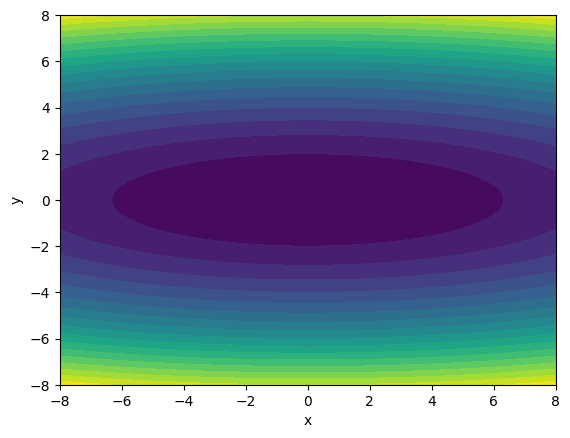

In [47]:
xi = np.linspace(-8, 8, 1000)
yi = np.linspace(-8, 8, 1000)
X,Y = np.meshgrid(xi, yi)
Z = X * X + 10 * Y * Y
def plt_contour(ax, X, Y, Z, arr = None):
    ax.set_xlim(-8, 8)
    ax.set_xlabel('x')
    ax.set_ylim(-8, 8)
    ax.set_ylabel('y')
    xx = X.flatten()
    yy = Y.flatten()
    zz = Z.flatten()
    ax.contourf(X, Y, Z, 20, cmap=plt.get_cmap('viridis'))
    if arr is not None:
        ax.plot(path[:, 0], path[:, 1], color='white')

g_coeff = np.array([2, 20])
def gr(x):
    return g_coeff * x

plt_contour(plt.gca(), X, Y, Z)
plt.show()

### 3. 모멘텀(Momentum)

- 배경 및 원리
> 진동(Oscillation) 현상과 같은 비효율을 개선
>
> 현재 업데이트에 이전 경사도의 가중치를 부여 하고 추가

경사 하강법

> $𝛉=𝛉−\eta\nabla_{𝛉}𝐽(𝛉)$

$\Rightarrow$ 모멘텀

> $\mathbf{v}_{t} = \gamma \mathbf{v}_{t-1} + \nabla_{𝛉}𝐽(𝛉)$
>
> $𝛉=𝛉−\mathbf{v}_t$

**이전 업데이트 방향을 일정 비율 유지하여 관성처럼 작용**

- 효과
> 진동 완화: 좁고 긴 골짜기 같은 지역에서 진동을 줄이고 안정적 수렴 유도
> 
> 정체 구간 극복: 기울기가 거의 0 에 가까운 지역을 관성의 효과로 쉽게 벗어남

- Convex: $z=x^2 + 10y^2$

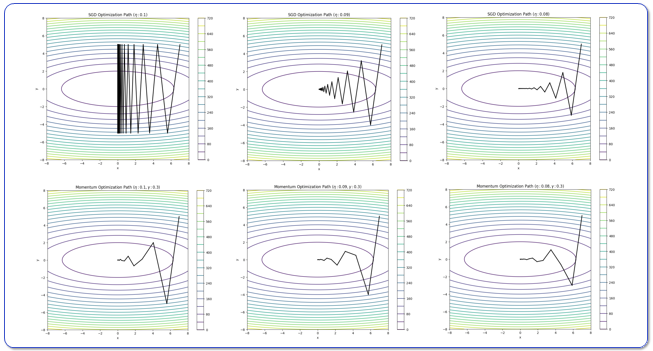

#### 경사하강법 대비 단점
- 하이퍼 파라미터 튜닝: 𝛾
- 연산량 및 메모리 증가


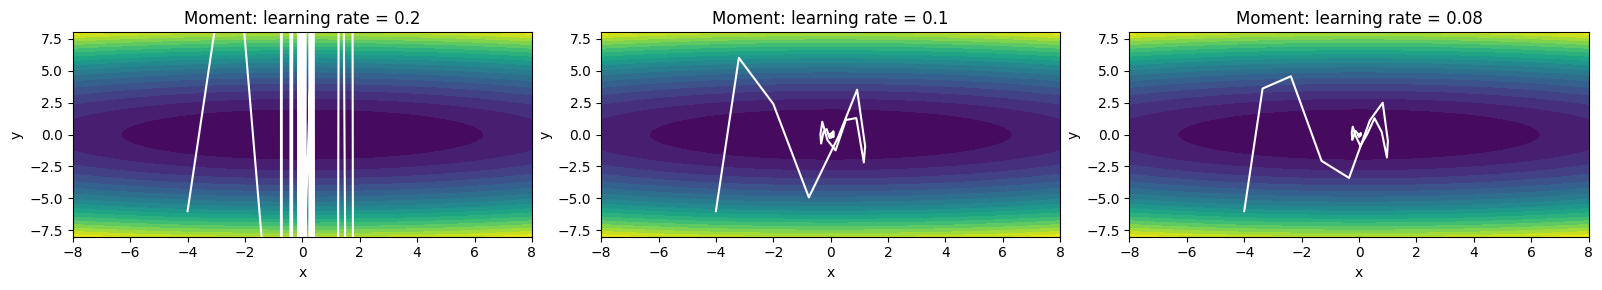

In [48]:
def momentum(x_start, step, g, discount=0.7, iteration=50):
    x = np.array(x_start, dtype='float64')
    passing_dot = [x.copy()]
    pre_grad = np.zeros_like(x)
    for _ in range(iteration):
        grad = g(x)
        pre_grad = pre_grad * discount + grad
        x -= pre_grad * step
        passing_dot.append(x.copy())
        if abs(sum(grad)) < 1e-6:
            break;
    return x, np.vstack(passing_dot)

fig, axes = plt.subplots(1, 3, figsize=(16, 3))

for learning_rate, ax in zip([0.2, 0.1, 0.08], axes):
    x, path = momentum(np.array([-4, -6]),learning_rate , gr)
    plt_contour(ax, X,Y,Z, path)
    ax.set_title('Moment: learning rate = {}'.format(learning_rate))

plt.tight_layout()
plt.show()

### 4 NAG(Nestrov Accelerated Gradient)
 
- 모멘텀의 방향성 전환에 반응성 향상
- 예상 위치를 계산하고 예상 위치에서 경사도를 사용

모멘텀

> $\mathbf{v}_{t} = \gamma \mathbf{v}_{t-1}\nabla_{𝛉}𝐽(𝛉)$
>
> $𝛉=𝛉−\mathbf{v}_t$

$\Rightarrow$ NAG

> $\mathbf{v}_{t} = \gamma \mathbf{v}_{t-1} + \nabla_{𝛉}𝐽(𝛉-\gamma\mathbf{v}_{t-1})$
>
> $𝛉=𝛉−\mathbf{v}_t$


# NAG(Nestrov Accelerated Gradient)

- 효과
> 빠른 수렴 속도, 특히 convex 문제에서
> 
> 최적점 근처에서 정밀한 업데이트

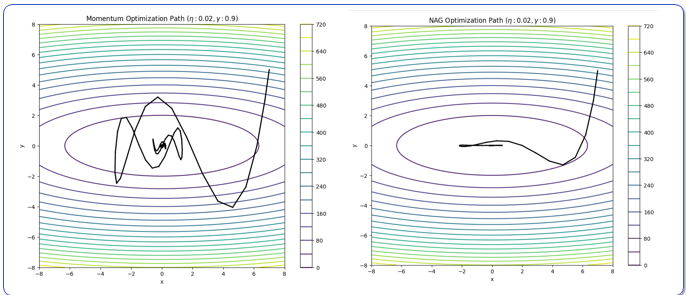

### 5: Adagrad(Adaptive Gradient Descent)

#### 배경 및 원리
- 전역적으로 부여된 파라미터가 개별적으로는 부적합한 경우 비효율 발생
- 파라미터 사이즈가 커질수록 괴리현상이 심해짐
- 개별 파라미터의 학습률을 조정하여 효율성 향상

경사 하강법

> $𝛉=𝛉−\eta\nabla_{𝛉}𝐽(𝛉)$

$\Rightarrow$ Adagrad
> $\mathbf{g} = \nabla_{\mathbf{\theta}}J(\mathbf{\theta})$
>
> $\mathbf{c}=\mathbf{c}+\mathbf{g} \circ \mathbf{g}$
>
> $\theta = \theta - \frac{\eta}{\sqrt{\mathbf{c} + \epsilon}} \circ \mathbf{g}$

- 효과
> 파라미터 맞춤 학습률 적용: 희소 경사도(경사도가 거의 0 에 가까운)에 학습 강화
>
> 학습 초기의 안정성 부여: 학습률에 민감성 감소
- 한계
> 경사도의 제곱의 누적효과로 인한 학습률의 지나친 축소

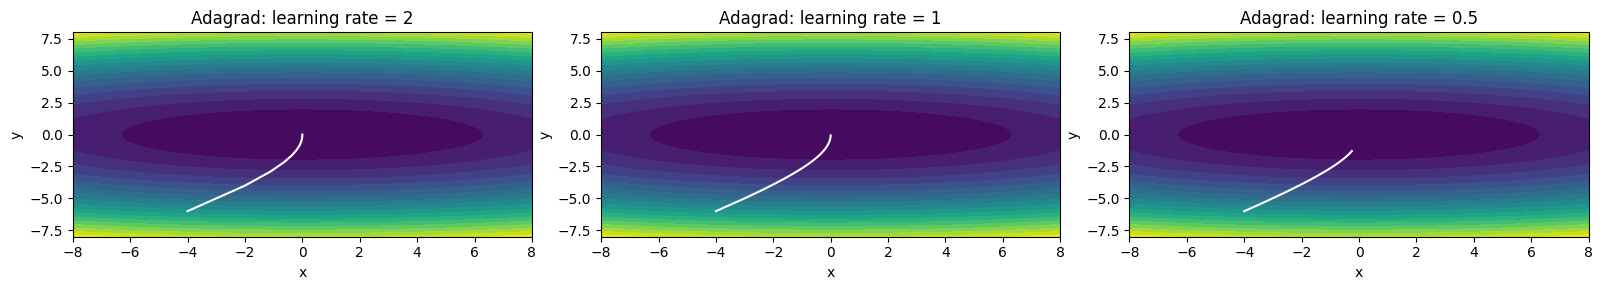

In [49]:
def adagrad(x_start, step, g, delta=1e-8, iteration=50):
    x = np.array(x_start, dtype='float64')
    passing_dot = [x.copy()]
    sum_grad = np.zeros_like(x)
    for _ in range(iteration):
        grad = g(x)
        sum_grad += grad * grad
        x -= step * grad / (np.sqrt(sum_grad) + delta)
        passing_dot.append(x.copy())
        if abs(sum(grad)) < 1e-6:
            break;
    return x, np.vstack(passing_dot)

fig, axes = plt.subplots(1, 3, figsize=(16, 3))

for learning_rate, ax in zip([2, 1, 0.5], axes):
    x, path = adagrad(np.array([-4, -6]), learning_rate, gr)
    plt_contour(ax, X,Y,Z, path)
    ax.set_title('Adagrad: learning rate = {}'.format(learning_rate))

plt.tight_layout()
plt.show()

#### Adagrad vs Momentum

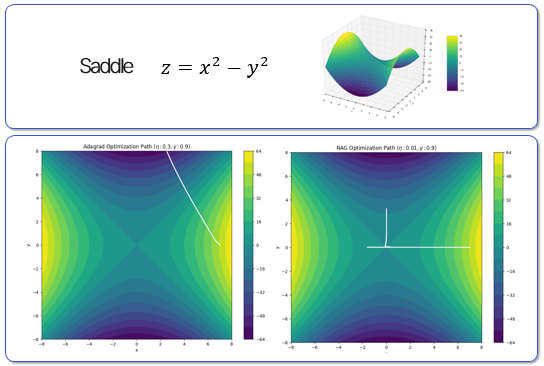

- 출처: https://tiddler.github.io/optimizers/

In [51]:
Z_2 = X * X - Y * Y
g_coeff_2 = np.array([2, -2])
def gr_2(x):
    return g_coeff_2 * x

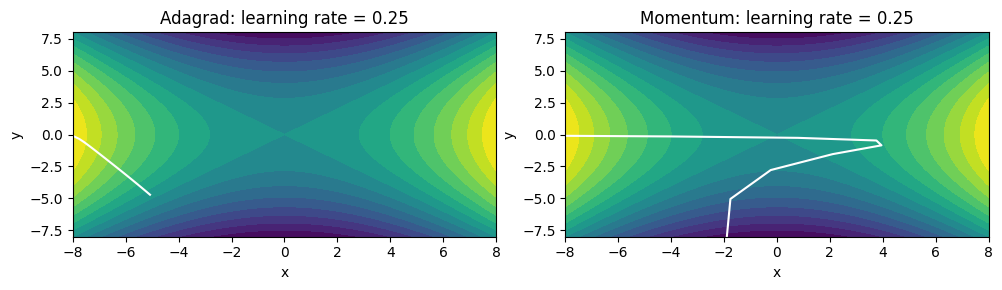

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
learning_rate = 0.25

x, path = adagrad(np.array([-8, -0.1]), learning_rate, gr_2)
plt_contour(axes[0], X,Y,Z_2, path)
axes[0].set_title('Adagrad: learning rate = {}'.format(learning_rate))

x, path = momentum(np.array([-8, -0.1]), learning_rate, gr_2)
plt_contour(axes[1], X,Y,Z_2, path)
axes[1].set_title('Momentum: learning rate = {}'.format(learning_rate))
plt.tight_layout()
plt.show()

### 6. Adadelta 와 RMSProp
#### 배경 및 원리
- Adagrad 의 학습률의 지나친 축소 현상에 대응
- 학습률을 완전히 누적시키지 않고, 이동 지수 평균을 적용

Adagrad
> $\mathbf{g} = \nabla_{\mathbf{\theta}}J(\mathbf{\theta})$
>
> $\mathbf{c}=\mathbf{c}+\mathbf{g} \circ \mathbf{g}$
>
> $\theta = \theta - \frac{\eta}{\sqrt{\mathbf{c} + \epsilon}} \circ \mathbf{g}$
>
> $\Rightarrow$ **RMSPrp**
> $\mathbf{g} = \nabla_{\mathbf{\theta}}J(\mathbf{\theta})$
>
> $\mathbf{c}=\gamma\mathbf{c}+(1-\gamma)\mathbf{g} \circ \mathbf{g}$
>
> $\theta = \theta - \frac{\eta}{\sqrt{\mathbf{c} + \epsilon}} \circ \mathbf{g}$
> 
> $\Rightarrow$ **Adadelta**
> $\mathbf{g} = \nabla_{\mathbf{\theta}}J(\mathbf{\theta})$
>
> $\mathbf{c}=\gamma\mathbf{c}+(1-\gamma)\mathbf{g} \circ \mathbf{g}$
>
> $\Delta\theta = -\frac{\sqrt{\Delta_{t-1} + \epsilon}}{\sqrt{\mathbf{c} + \epsilon}} \circ \mathbf{g}$
>
> $\theta = \theta + \Delta\theta$
>
> $\Delta_t = \gamma \Delta_{t-1} + (1 - \gamma) \Delta\theta \circ \Delta\theta$

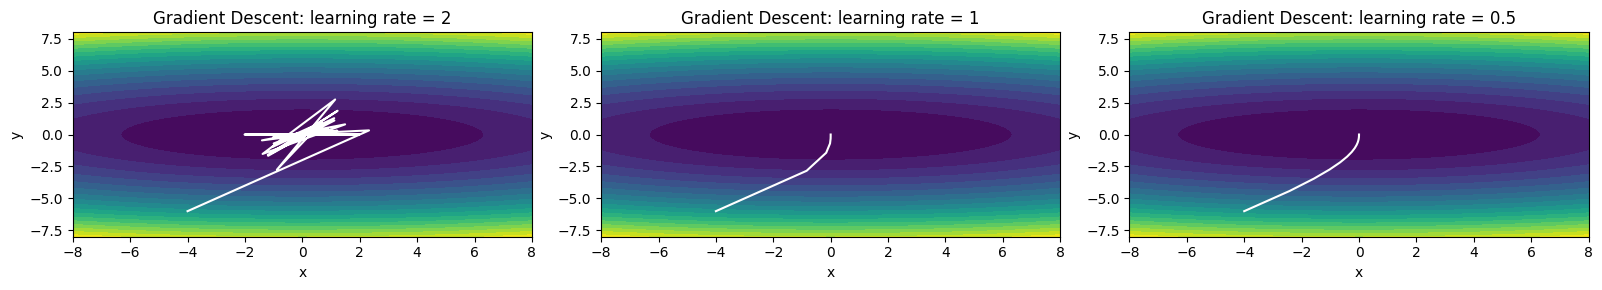

In [53]:
def rmsprop(x_start, step, gradient, rms_decay=0.9, delta=1e-8, iteration=50):
    x = np.array(x_start, dtype='float64')
    sum_grad = np.zeros_like(x)
    passing_dot = [x.copy()]
    for _ in range(iteration):
        grad = gradient(x)
        sum_grad = rms_decay * sum_grad + (1 - rms_decay) * grad * grad
        x -= step * grad / (np.sqrt(sum_grad) + delta)
        passing_dot.append(x.copy())
        if abs(sum(grad)) < 1e-6:
            break;
    return x, np.vstack(passing_dot)

fig, axes = plt.subplots(1, 3, figsize=(16, 3))

for learning_rate, ax in zip([2, 1, 0.5], axes):
    x, path = rmsprop(np.array([-4, -6]), learning_rate, gr)
    plt_contour(ax, X,Y,Z, path)
    ax.set_title('Gradient Descent: learning rate = {}'.format(learning_rate))

plt.tight_layout()
plt.show()

#### 효과

<table border="1" style="border-collapse: collapse; width: 100%;">
  <thead>
    <tr style="background-color: #eeeeee;">
      <th></th>
      <th></th>
      <th style="padding: 10px; text-align: center;">Adagrad</th>
      <th style="padding: 10px; text-align: center;">Adadelta</th>
      <th style="padding: 10px; text-align: center;">RMSProp</th>
    </tr>
  </thead>
  <tbody>
    <tr style="background-color: #ffffff;">
      <td colspan="2" style="background-color: #eeeeee;padding: 10px; text-align: center; vertical-align: middle;"><strong>공통적 효과</strong></td>
      <td colspan="3" style="padding: 10px; text-align: center;">수렴 안정성 향상<br>파라메터 별 경사도 스케일 보정 → 수렴에 이르기 어려운 파라메터의 학습 개선<br>초기의 민감도 완화</td>
    </tr>
    <tr style="background-color: #ffffff;">
      <td rowspan="2" style="background-color: #eeeeee;padding: 10px; text-align: center; vertical-align: middle;"><strong>개별 효과</strong></td>
      <td style="background-color: #eeeeee;padding: 10px; text-align: center; vertical-align: middle;"><strong>장점</strong></td>
      <td style="padding: 10px;">희소한 feature에 강함</td>
      <td style="padding: 10px;">학습률이 없어,<br>학습률의 튜닝 불필요<br>단위 일관성 유지</td>
      <td style="padding: 10px;">Adagrad의 학습률<br>지나친 축소현상 완화<br>Adadelta 보다 연산 지원이<br>적게 들어감</td>
    </tr>
    <tr style="background-color: #ffffff;">
      <td style="background-color: #eeeeee;padding: 10px; text-align: center; vertical-align: middle;"><strong>단점</strong></td>
      <td style="padding: 10px;">학습률이 너무 작아져<br>효율성이 오히려 떨어짐<br>Adadelta 대비 단위, 학습률 튜닝 필요,<br>단위 일관성 비유지</td>
      <td style="padding: 10px;">구조가 복잡하며,<br>연산 자원이 상대적으로 많이 필요</td>
      <td style="padding: 10px;">Adagrad 연산량 증가<br>Adadelta 대비 단위, 학습률 튜닝 필요,<br>단위 일관성 비유지</td>
    </tr>

  </tbody>
</table>

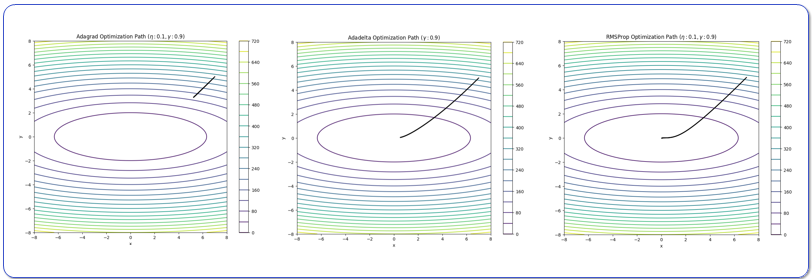

### 7. Adam(Adaptive Moment Estimation)
#### Momentum+RMSProp

- 편향 보정
> 초기의 m, n 은 0 이에 따라 지수이동평균은 0 에 치우치게 됨
> 
> $\beta_1$,$\beta_2$ 1 에 가깝게 설정 (보통 $\beta_1: 0.9$로 $\beta_1: 0.999$설정)
> 
> ▷ 이를 보정하기 위한 설정이 편향 보정

$\mathbf{g} = \nabla_{\theta} J(\theta)$

$\mathbf{m} = \beta_1 \mathbf{m} + (1 - \beta_1) \mathbf{g}$

$\mathbf{v} = \beta_2 \mathbf{v} + (1 - \beta_2) \mathbf{g} \circ \mathbf{g}$

$\hat{\mathbf{m}} = \frac{\mathbf{m}}{1 - \beta_1^t}$ $\hat{\mathbf{v}} = \frac{\mathbf{v}}{1 - \beta_2^t}$

$\theta = \theta - \frac{\eta}{\sqrt{\hat{\mathbf{v}}} + \epsilon} \hat{\mathbf{m}}$

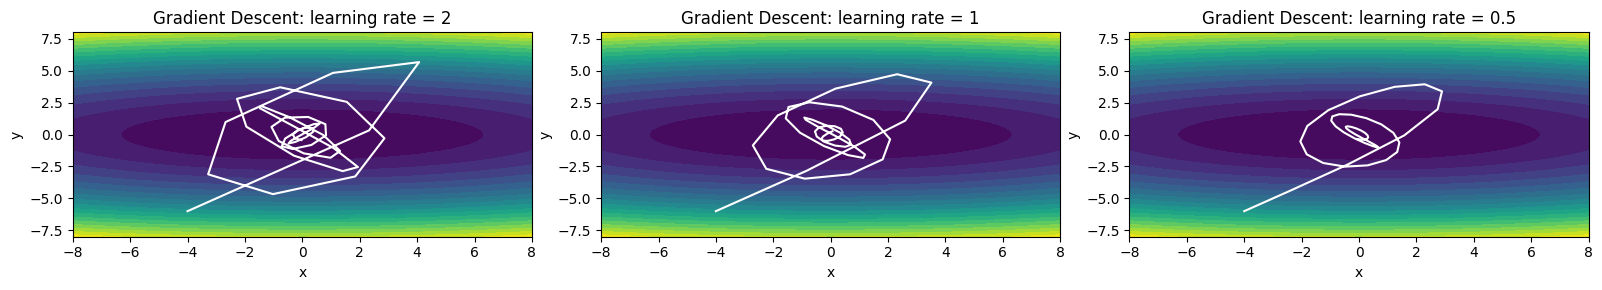

In [54]:
def adam(x_start, step, gradient, beta1=0.9, beta2=0.999, delta=1e-8, iteration=50):
    x = np.array(x_start, dtype='float64')
    sum_m = np.zeros_like(x)
    sum_v = np.zeros_like(x)
    passing_dot = [x.copy()]
    for _ in range(iteration):
        grad = gradient(x)
        sum_m = beta1 * sum_m + (1 - beta1) * grad
        sum_v = beta2 * sum_v + (1 - beta2) * grad * grad
        x -= step * sum_m / (np.sqrt(sum_v + delta))
        passing_dot.append(x.copy())
        if abs(sum(grad)) < 1e-6:
            break;
    return x, np.vstack(passing_dot)

fig, axes = plt.subplots(1, 3, figsize=(16, 3))

for learning_rate, ax in zip([2, 1, 0.5], axes):
    x, path = adam(np.array([-4, -6]), learning_rate , gr)
    plt_contour(ax, X,Y,Z, path)
    ax.set_title('Gradient Descent: learning rate = {}'.format(learning_rate))

plt.tight_layout()
plt.show()

#### 효과

- 모수별 학습률 자동 조절
- 하이퍼 파라메터 설정에 비교적 덜 민감

#### 단점
- 빠른 수렴으로 오히려 과적합을 유도할 수 있음
- 메모리 소모가 크고 연산량이 많음

|   | 저장 변수 | 추정 연산량 |
| --- | --- | --- |
| SGD | 0 | O(N) |
| Momentum | N(이전 경사도) | O(2N) |
| Adagrad | N(누적 경사도) | O(2N) |
| RMSProp | N(기울기 제곱) | O(2N) |
| Adadelta | 2N(기울기 제곱, 이전 업데이트 크기) | O(3N) |
| Adam | 2N(모멘텀, 분산) | O(4N) |


### 8. 비교 분석

|   | 장점 | 단점 |
| --- | --- | --- |
| SGD<br/>(Stochastic Gradient Descent) | 구현이 간단, 계산량이 적어 튜닝이 잘 되면 강력<br/>convex 문제에 이론적으로 수렴 보장 | 기울기 진동 심함<br/>학습률 튜닝이 까다로움 |
| Momentum | 진동 억제<br/>SGD 보다 안정적 | 모멘텀 계수, 학습률 튜닝 필요 |
| Adagrad | 파라메터별 적응형 학습률 적용으로 학습 효율화<br/>파라메터 학습에 강함<br/>학습 초기 안정성 높음 | 학습률 과도 축소 문제<br/>학습률 튜닝 필요 |
| RMSProp | Adagrad 의 학습률 과도 축소 문제 해결 | 학습률, 감쇠율 튜닝 필요 |
| Adadelta | 학습률 튜닝이 필요가 없음<br/>Adagrad 의 학습률 과도 축소 문제 해결 | 연산 자원이 상대적 많이 필요<br/>Adam 에 비해 성능이 밀리고 강점이 약함 |
| Adam | 높은 범용성 | 과적합 위험<br/>연산 자원이 상대적 많이 필요 |
